In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew

# Setting visualisasi
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

# Load Data
train = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv')
test = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv')

print(f"Shape Train: {train.shape}")
print(f"Shape Test: {test.shape}")

Shape Train: (1460, 81)
Shape Test: (1459, 80)


# Data Preparation

## Analyze data

Text(0.5, 1.0, 'SalePrice distribution (Original)')

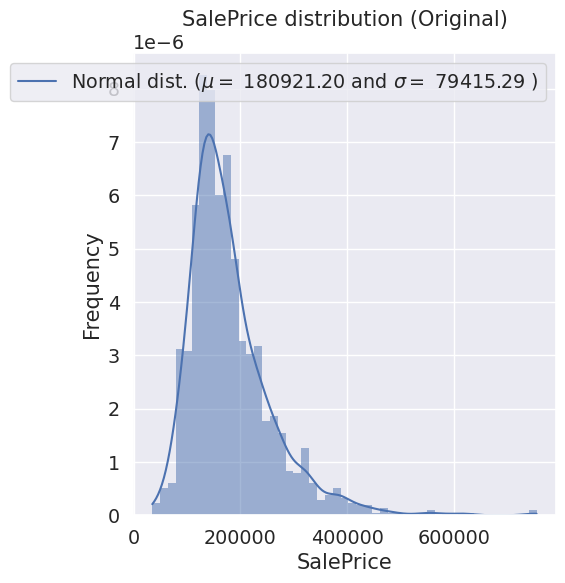

In [47]:
# Histogram Distribusi Harga Asli
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
sns.histplot(train['SalePrice'], kde=True, stat="density", linewidth=0)
(mu, sigma) = norm.fit(train['SalePrice'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution (Original)')

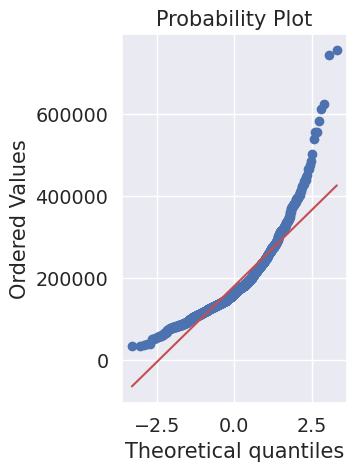

Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


In [48]:
# QQ-Plot (Probability Plot)
# Jika titik-titik biru melenceng jauh dari garis merah, berarti TIDAK normal.

plt.subplot(1, 2, 2)
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

print(f"Skewness: {train['SalePrice'].skew()}")
print(f"Kurtosis: {train['SalePrice'].kurt()}")

## Log Transformation

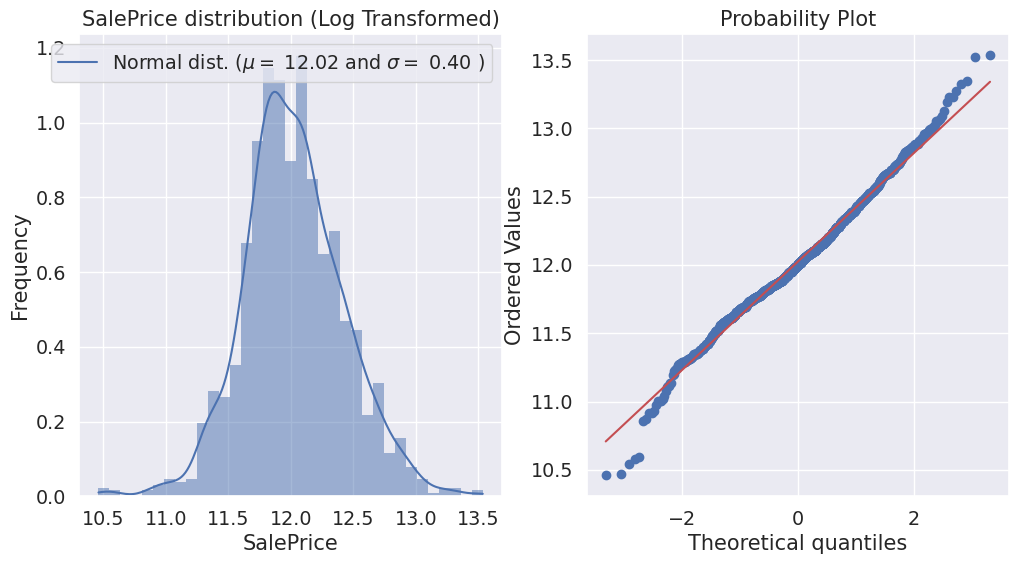

In [49]:
# Menggunakan numpy log1p (log(1+x))
train["SalePrice"] = np.log1p(train["SalePrice"])

# setelah di-log
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
sns.histplot(train['SalePrice'], kde=True, stat="density", linewidth=0)
(mu, sigma) = norm.fit(train['SalePrice'])
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution (Log Transformed)')

plt.subplot(1, 2, 2)
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

## Correlation Heatmap 

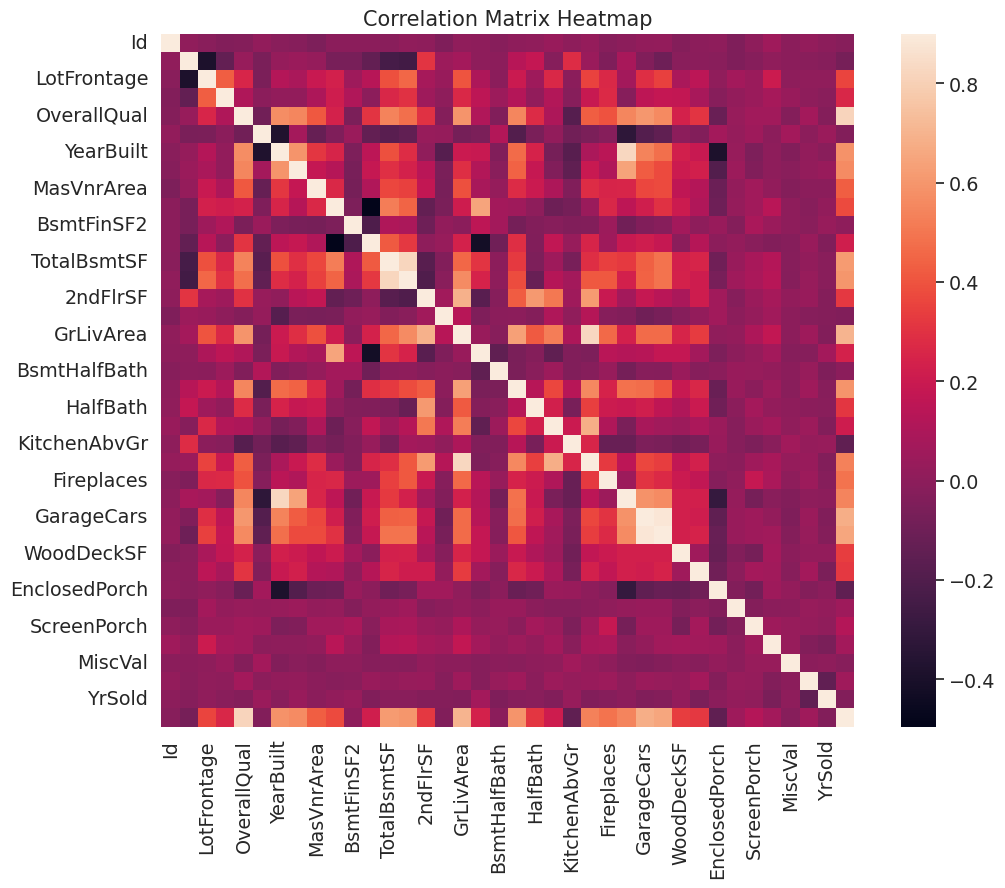

In [50]:
# korelasi antar data numerik

corrmat = train.corr(numeric_only=True)

plt.figure(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.title("Correlation Matrix Heatmap")
plt.show()

## Top 10 Important Feature

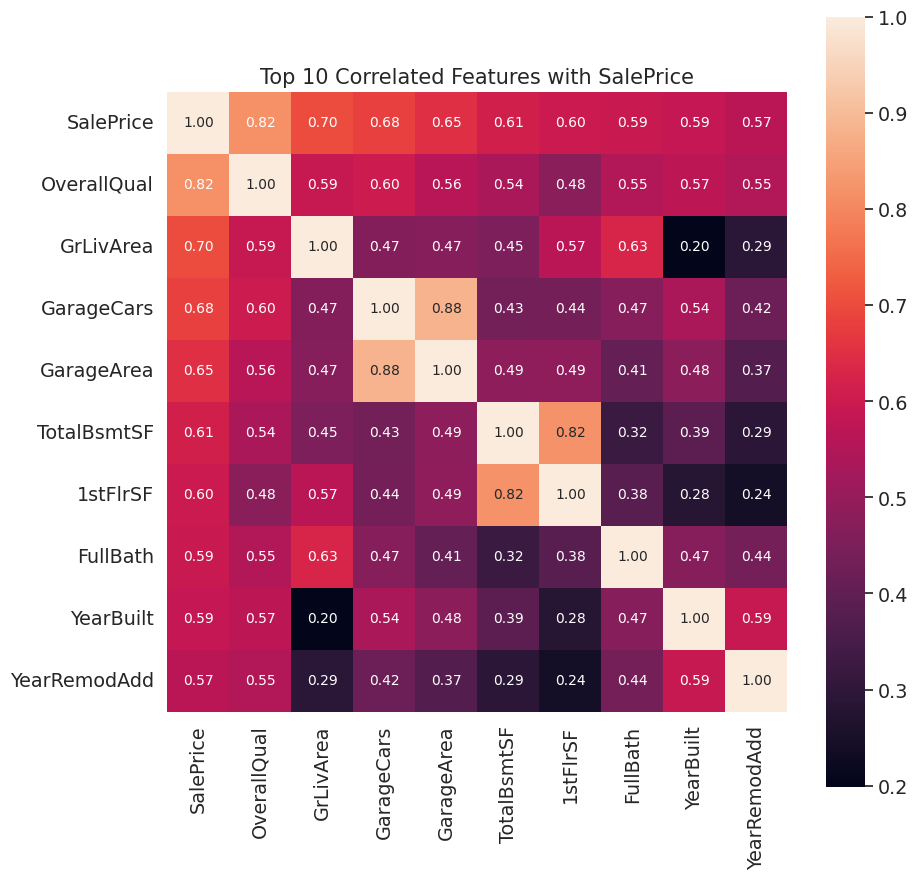

In [51]:
# Mengambil 10 fitur dengan korelasi tertinggi terhadap SalePrice
k = 10 
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index

cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)

plt.figure(figsize=(10, 10))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, 
                 yticklabels=cols.values, xticklabels=cols.values)
plt.title("Top 10 Correlated Features with SalePrice")
plt.show()

### Correlation Analysis

Based on the heatmap, here are the key takeaways:

* **Strongest Predictors:** `OverallQual` (0.82) and `GrLivArea` (0.70) are the most significant features affecting `SalePrice`.
* **Multicollinearity Alert:**
    * `GarageCars` and `GarageArea` are highly correlated (**0.88**). They basically hold the same information.
    * `TotalBsmtSF` and `1stFlrSF` are also strongly correlated (**0.82**).
    
    **Action:** Since these features provide redundant information, we might need to apply regularization or feature selection to prevent overfitting.

## Missing values

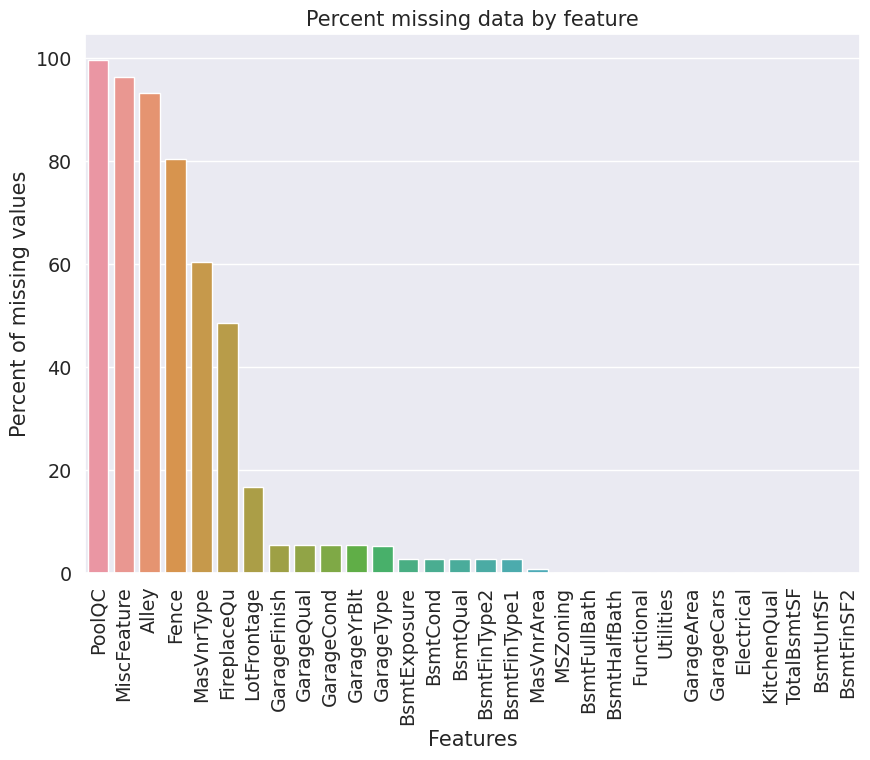

              Missing Ratio
PoolQC            99.657417
MiscFeature       96.402878
Alley             93.216855
Fence             80.438506
MasVnrType        60.500171
FireplaceQu       48.646797
LotFrontage       16.649538
GarageFinish       5.447071
GarageQual         5.447071
GarageCond         5.447071


In [52]:
# Menggabungkan data train dan test untuk melihat total missing value
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
# Hapus Id di all_data (if available)
if 'Id' in all_data.columns:
    all_data.drop(['Id'], axis=1, inplace=True)

# Hitung persentase missing value
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]

missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})

# Plot Missing Value
f, ax = plt.subplots(figsize=(10, 7))
plt.xticks(rotation='vertical')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
plt.show()

print(missing_data.head(10))

## Handle missing values

In [53]:
# (Ganti NaN jadi "None")
cols_fill_none = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 
                  'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
                  'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                  'BsmtFinType2', 'MasVnrType']

for col in cols_fill_none:
    all_data[col] = all_data[col].fillna('None')

# Kelompok Numerik yang artinya 0 (Misal tidak punya garasi, luasnya 0)
cols_fill_0 = ['GarageYrBlt', 'GarageArea', 'GarageCars', 
               'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 
               'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

for col in cols_fill_0:
    all_data[col] = all_data[col].fillna(0)

# LotFrontage (Diisi Median Tetangga)
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

# sisa printilan (Data umum seperti Listrik, Exterior) diisi Modus (angka yg paling sering muncul)
cols_mode = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 
             'Exterior2nd', 'SaleType', 'Functional', 'Utilities']
for col in cols_mode:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

# Cek ulang apakah masih ada missing values
total_missing = all_data.isnull().sum().max()
print(f"Jumlah Missing Value sekarang: {total_missing}")

Jumlah Missing Value sekarang: 0


## Outliers

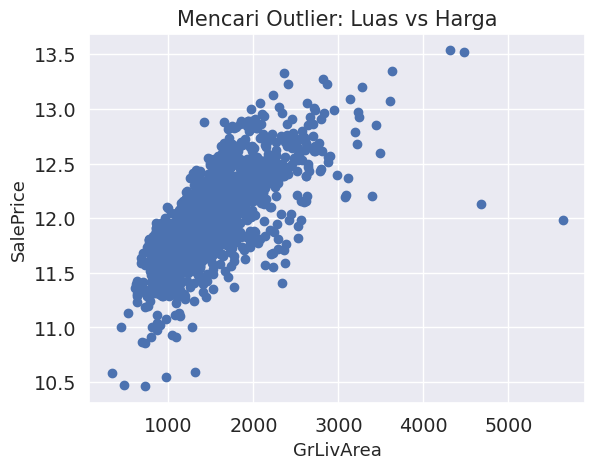

In [54]:
# plot GrLivArea vs SalePrice (TARGET)

fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.title('Mencari Outlier: Luas vs Harga')
plt.show()

### Handle outliers

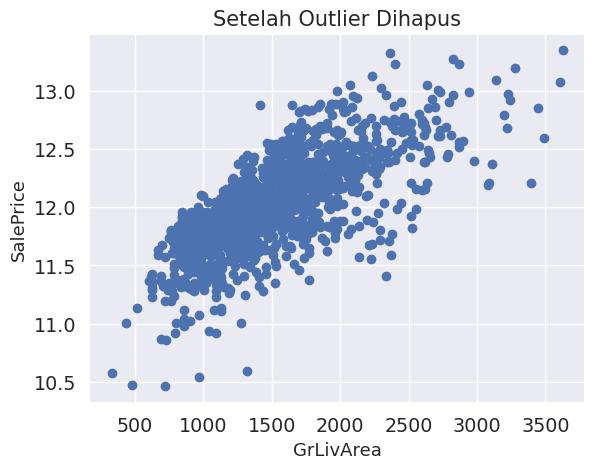

Outlier berbahaya sudah hilang. Data siap untuk Feature Engineering!


In [55]:
# Menghapus Outlier
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

fig, ax = plt.subplots()
ax.scatter(train['GrLivArea'], train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.title('Setelah Outlier Dihapus')
plt.show()

print("Outlier berbahaya sudah hilang. Data siap untuk Feature Engineering!")

## Label Encoding

In [56]:
from sklearn.preprocessing import LabelEncoder

# Daftar kolom Ordinal
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# Proses mengubah teks jadi angka 
for c in cols:
    lbl = LabelEncoder() 
    # Tipe data sting 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

print(f"Shape setelah Label Encoding: {all_data.shape}")

Shape setelah Label Encoding: (2919, 79)


## Feature Engineering

In [57]:
# Created new feature : Total Square Feet
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# Mengatasi Skewness pada Fitur Numerik (Box-Cox Transform)
from scipy.stats import skew
from scipy.special import boxcox1p

# Cari kolom numerik
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Hitung kemiringan data (skewness)
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = skewed_feats[abs(skewed_feats) > 0.75]
print(f"Ada {len(skewness)} fitur numerik yang miring (skewed) dan akan diperbaiki.")

# Terapkan Box-Cox Transformation
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

print("Transformasi Box-Cox selesai & Fitur TotalSF berhasil dibuat.")

Ada 38 fitur numerik yang miring (skewed) dan akan diperbaiki.
Transformasi Box-Cox selesai & Fitur TotalSF berhasil dibuat.


In [58]:
# DOMAIN KNOWLEDGES

# Fitur Boolean (Ya/Tidak)
all_data['HasPool'] = all_data['PoolArea'].apply(lambda x: 1 if x > 0 else 0)

# Apakah punya lantai 2?
all_data['Has2ndFloor'] = all_data['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

# Apakah punya garasi?
all_data['HasGarage'] = all_data['GarageArea'].apply(lambda x: 1 if x > 0 else 0)

# Apakah punya basement?
all_data['HasBsmt'] = all_data['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

# Apakah punya perapian (fireplace)?
all_data['HasFireplace'] = all_data['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


# Fitur Interaksi (Interaction Terms)
all_data['IsRemodeled'] = (all_data['YearRemodAdd'] != all_data['YearBuilt']).astype(int)

# Total Kamar Mandi (Full Bath + 0.5 * Half Bath)
all_data['TotalBath'] = (all_data['FullBath'] + (0.5 * all_data['HalfBath']) +
                         all_data['BsmtFullBath'] + (0.5 * all_data['BsmtHalfBath']))

print("Fitur tambahan berhasil dibuat: HasPool, Has2ndFloor, HasGarage, HasBsmt, HasFireplace, IsRemodeled, TotalBath")

Fitur tambahan berhasil dibuat: HasPool, Has2ndFloor, HasGarage, HasBsmt, HasFireplace, IsRemodeled, TotalBath


## One-Hot Encoding

In [59]:
# One-Hot Encoding (Get Dummies) untuk semua sisa kolom kategori
all_data = pd.get_dummies(all_data)
print(f"Shape data final (sangat lebar): {all_data.shape}")

Shape data final (sangat lebar): (2919, 230)


## Final split

In [60]:
# Pisahkan kembali jadi Train dan Test
train_data = all_data[:ntrain]
test_data = all_data[ntrain:]

print("DATA PREPARATION SELESAI!")

DATA PREPARATION SELESAI!


# Modelling

In [61]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

# Fungsi CV
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train_data.values)
    rmse= np.sqrt(-cross_val_score(model, train_data.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

print("Fungsi validasi siap!")

Fungsi validasi siap!


## Define Model

In [62]:
# LASSO Regression
# Model sederhana yang jago membuang fitur tidak penting
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

# Elastic Net Regression
# Saudara Lasso, tapi lebih fleksibel
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

# Kernel Ridge Regression
# Bagus untuk menangkap pola melengkung (non-linear)
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

# Gradient Boosting Regression
# Model Tree yang belajar dari kesalahan sebelumnya
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

# XGBoost 
# Model legendaris Kaggle
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, random_state =7, nthread = -1)

# 6. LightGBM
# Versi lebih ringan dan cepat dari Boosting
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11,
                              verbose=-1) # verbose -1 biar gak berisik warningnya

print("Semua model ready tempur bolo!")

Semua model ready tempur bolo!


## Training

In [63]:
print("Mulai menghitung skor Cross-Validation (Mohon tunggu)...")

score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

score = rmsle_cv(model_xgb)
print("XGBoost score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

score = rmsle_cv(model_lgb)
print("LightGBM score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

print("\nTraining model final ke seluruh data...")
#fit ulang ke seluruh data untuk prediksi akhir
lasso_model_full = lasso.fit(train_data, y_train)
enet_model_full = ENet.fit(train_data, y_train)
krr_model_full = KRR.fit(train_data, y_train)
gboost_model_full = GBoost.fit(train_data, y_train)
xgb_model_full = model_xgb.fit(train_data, y_train)
lgb_model_full = model_lgb.fit(train_data, y_train)

print("Training Selesai!")

Mulai menghitung skor Cross-Validation (Mohon tunggu)...

Lasso score: 0.1236 (0.0175)
ElasticNet score: 0.1235 (0.0175)
Kernel Ridge score: 0.1622 (0.0122)
Gradient Boosting score: 0.1227 (0.0132)
XGBoost score: 0.1227 (0.0109)
LightGBM score: 0.1237 (0.0104)

Training model final ke seluruh data...
Training Selesai!


## Submition

In [74]:
import pandas as pd
import numpy as np

# 1. Baca file yang tadi hasilnya masih 11.xxx
df = pd.read_csv('submission_optimized_blending.csv')

# 2. Perbaiki (Ubah Logaritma -> Harga Asli)
df['SalePrice'] = np.expm1(df['SalePrice'])

# 3. Cek Preview (Harusnya sekarang sudah ratusan ribu, misal 122372...)
print("Preview Data Benar:")
print(df.head())

# 4. Simpan dengan nama baru
df.to_csv('submission_optimized_blending_FIXED.csv', index=False)
print("\nFile 'submission_optimized_blending_FIXED.csv' SUDAH JADI. Silakan Download!")

Preview Data Benar:
     Id      SalePrice
0  1461  122372.581230
1  1462  154381.315029
2  1463  178313.057098
3  1464  191050.198996
4  1465  187235.862866

File 'submission_optimized_blending_FIXED.csv' SUDAH JADI. Silakan Download!


In [136]:
# --- INSTALL LIBRARY STACKING (Jika belum ada) ---
# !pip install mlxtend  # (Biasanya di Kaggle sudah ada, tapi kalau error uncomment baris ini)

from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from datetime import datetime

# 1. SETUP MODEL (Sama seperti The Avengers tadi)
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
elasticnet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
krr = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
gboost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, 
                                   max_features='sqrt', min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
xgb_model = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200, reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, random_state =7, nthread = -1)
lgbm_model = lgb.LGBMRegressor(objective='regression',num_leaves=5, learning_rate=0.05, n_estimators=720,
                               max_bin = 55, bagging_fraction = 0.8, bagging_freq = 5, feature_fraction = 0.2319,
                               feature_fraction_seed=9, bagging_seed=9, min_data_in_leaf =6, 
                               min_sum_hessian_in_leaf = 11, verbose=-1)

# 2. DEFINISI STACKING (INI RAHASIANYA!)
# XGBoost bertindak sebagai "Bos" (Meta-Regressor) yang belajar dari model lain
stack_gen = StackingCVRegressor(regressors=(lasso, elasticnet, krr, gboost, xgb_model, lgbm_model),
                                meta_regressor=xgb_model,
                                use_features_in_secondary=True)

print("Mulai Training Stacking Model (Akan memakan waktu 3-5 menit)...")
# Kita fit ke data train
stack_gen_model = stack_gen.fit(np.array(train_data), np.array(y_train))
print("Training Stacking Selesai!")

# 3. PREDIKSI
print("Melakukan Prediksi...")
stack_gen_preds = stack_gen_model.predict(np.array(test_data))
lasso_preds = lasso_model_full.predict(test_data)
elasticnet_preds = enet_model_full.predict(test_data)
krr_preds = krr_model_full.predict(test_data)
gboost_preds = gboost_model_full.predict(test_data)
xgb_preds = xgb_model_full.predict(test_data)
lgbm_preds = lgb_model_full.predict(test_data)

# 4. BLENDING FINAL (Gabungkan Stacking + Model Individu)
# Kita beri bobot besar ke hasil Stacking (0.7)
weighted_prediction = (0.70 * stack_gen_preds) + \
                      (0.10 * gboost_preds) + \
                      (0.10 * xgb_preds) + \
                      (0.05 * lasso_preds) + \
                      (0.05 * lgbm_preds)

# 5. Konversi ke Harga Asli
final_predictions = np.expm1(weighted_prediction)

# 6. Simpan Submission
submission_stacking = pd.DataFrame({
    "Id": test_id,
    "SalePrice": final_predictions
})

# Cek agar tidak 'inf' lagi
print(submission_stacking.head())

submission_stacking.to_csv('submission_ultimate_stacking.csv', index=False)
print("File 'submission_ultimate_stacking.csv' SIAP! Ini adalah upaya terbaik kita.")

Mulai Training Stacking Model (Akan memakan waktu 3-5 menit)...
Training Stacking Selesai!
Melakukan Prediksi...
     Id      SalePrice
0  1461  121001.785241
1  1462  159461.496356
2  1463  182164.445094
3  1464  194226.510892
4  1465  192147.825137
File 'submission_ultimate_stacking.csv' SIAP! Ini adalah upaya terbaik kita.
